In [ ]:
import numpy as np
import pandas as pd
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [10]:
df = pd.read_csv('scaled_filtered_24_4_10.csv')

In [15]:
# df = df.drop('Unnamed: 0', axis =1)
df = df[df['party_total_hpratio'] <= 1]
df.shape

(10132, 62)

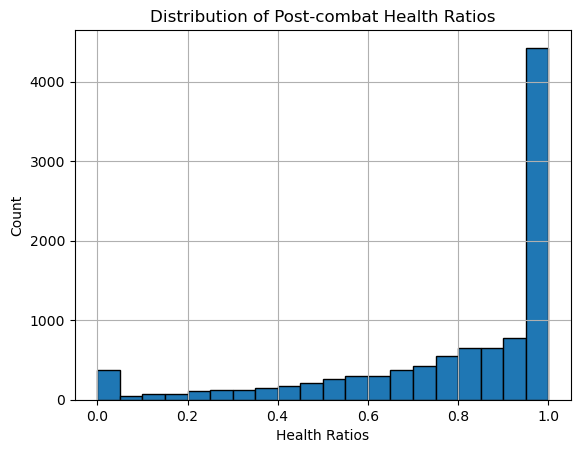

In [20]:
plt.hist(df['party_total_hpratio'], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Health Ratios')
plt.ylabel('Count')
plt.title('Distribution of Post-combat Health Ratios')
plt.grid(True)  # Add grid

plt.savefig('distribution_of_hpratios.png')

In [21]:
df[df['party_total_hpratio'] == 0].shape

(332, 62)

In [ ]:
plt.scatter(df_temp['party_total_hpratio'],df_temp['weighted_monster_level'])

In [ ]:
df.columns

In [ ]:
pred_features = ['party_size','number_of_rounds',
                       'monster_number','monster_total_level','party_total_ac',
                      'party_total_prof_bonus',
                      'party_total_strength', 'party_total_dexterity',
                       'party_total_constitution',
                      'party_total_intelligence',
                      'party_total_wisdom','party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots',
                       'party_total_charisma','monster_player_ratio', 'Druid','Cleric','Wizard','Rogue','Warlock','Sorcerer',
                       'Blood Hunter','Monk','Bard','Barbarian','Fighter','Paladin','Ranger',
                      'weighted_monster_level']

## Baseline Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming df is your DataFrame

# Prepare your data
X = df['monster_total_level'].values.reshape(-1,1) # Predictor
y = df['party_total_hpratio']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=455)

# Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Baseline Model RMSE:", rmse)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


# Prepare your data
X = df['weighted_monster_level'].values.reshape(-1,1)  # Predictor

y = df['party_total_hpratio']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Baseline Model RMSE:", rmse)


## Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# Defining the target variable
target = 'party_total_hpratio'

# Preparing the features and target variable
X_rf = df[features_to_include].copy()
y = df[target].copy()

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)



# Creating the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100)

# Training the model
regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred = regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
rmse
plt.scatter(y_test,y_pred)

In [ ]:
rmse

## PLA

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Scaling numerical values
df_pls = df[pred_features]  
df_pls['health_ratio'] = df['party_total_hpratio']  

# Identify numerical columns
numerical_cols = df_pls.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the list of categorical columns (one-hot encoded class columns) and the column to be predicted
excluded_cols = ['Druid', 'Cleric', 'Wizard', 'Rogue', 'Warlock', 'Sorcerer',
                    'Blood Hunter', 'Monk', 'Bard', 'Barbarian', 'Fighter',
                    'Paladin', 'Ranger','health_ratio']

# Exclude needed columns from the list of numerical columns
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]
assert all(col in df_pls.columns for col in numerical_cols), "Some columns are missing in the DataFrame."

scaler = StandardScaler()
df_pls_num = df_pls[numerical_cols]
# Apply fit_transform to each column
scaled_data = df_pls_num.apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=df_pls_num.columns)
scaled_df.shape
df_pls = pd.concat([scaled_df, df_pls[excluded_cols]], axis=1)




X_PLA = df_pls[pred_features].copy()
Y = df_pls['health_ratio']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_PLA, Y)

# Initial PLS model fitting with a predefined number of components
pls = PLSRegression(n_components=15)
pls.fit(X_train, y_train)
Y_pred = pls.predict(X_test)
r_squared = r2_score(y_test, Y_pred)
print("R-squared:", r_squared)

# loadings = pls.x_loadings_

# def plot_correlation_loadings(loadings, feature_names=df_pls[pred_features].columns.tolist()):
#     plt.figure(figsize=(10, 7))
#     for i in range(loadings.shape[0]):
#         plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.1)
#         plt.text(loadings[i, 0], loadings[i, 1], 'Var'+str(i+1) if not feature_names else feature_names[i],
#                  verticalalignment='bottom', horizontalalignment='right')

#     plt.xlabel("Component 1 Loadings")
#     plt.ylabel("Component 2 Loadings")
#     plt.title('PLS Correlation Loadings Plot')
#     plt.grid(True)
#     plt.axhline(0, color='black',linewidth=0.5)
#     plt.axvline(0, color='black',linewidth=0.5)
#     plt.xlim(-0.50, 0.50)
#     plt.ylim(-0.50, 0.50)
#     plt.show()

# Assuming you don't have specific names, using default Var1, Var2, ...
# plot_correlation_loadings(loadings)







In [ ]:
plt.scatter(y_test,Y_pred)

In [ ]:
from sklearn.decomposition import PCA


# Scaling numerical values
df_pca = df[pred_features]  
df_pca['health_ratio'] = df['party_total_hpratio']  

# Identify numerical columns
numerical_cols = df_pca.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the list of categorical columns (one-hot encoded class columns) and the column to be predicted
excluded_cols = ['Druid', 'Cleric', 'Wizard', 'Rogue', 'Warlock', 'Sorcerer',
                    'Blood Hunter', 'Monk', 'Bard', 'Barbarian', 'Fighter',
                    'Paladin', 'Ranger','health_ratio']

# Exclude needed columns from the list of numerical columns
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]
assert all(col in df_pca.columns for col in numerical_cols), "Some columns are missing in the DataFrame."

scaler = StandardScaler()
df_pca_num = df_pca[numerical_cols]
# Apply fit_transform to each column
scaled_data = df_pca_num.apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=df_pca_num.columns)
scaled_df.shape
df_pca = pd.concat([scaled_df, df_pca[excluded_cols]], axis=1)

X_PCA = df_pca[pred_features].copy()
Y = df_pca['health_ratio']

pca = PCA(n_components=2)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_PCA)

X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

pca.explained_variance_ratio_, mse

In [ ]:
plt.scatter(y_test,y_pred)